In [1]:
from ipywidgets import interactive

from PIL import Image as im

import numpy as np
from scipy import signal as sg
from scipy.ndimage import filters, measurements, morphology, gaussian_laplace

from skimage.morphology import skeletonize, remove_small_objects
from skimage.measure import label, regionprops

import sys
sys.path.append("/home/tintin/rongheng/cv/")
from lib.image_lib import load_img, show_img, show_hist, resize_img, save_img, normalize
from lib.edge_lib import threshold, get_points, overlay_points

# Input image

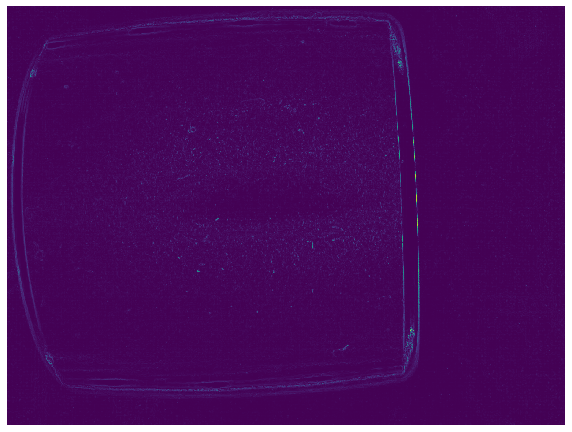

In [28]:
img = load_img("b0.3.jpg", size=(2448, 2448), array=True) 

from skimage.filters import sobel
elevation_map = sobel(img)
show_img(elevation_map)

# Cropped Image

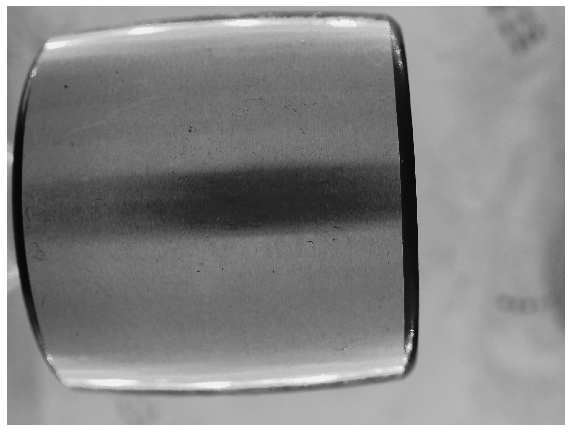

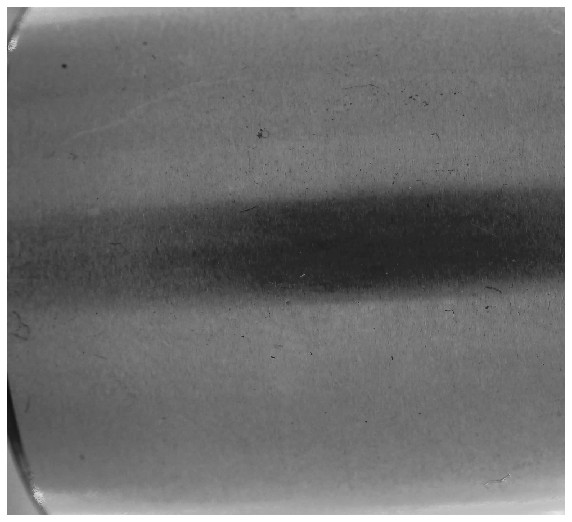

In [11]:
show_img(img, color="bw")
cropped_img = img.crop((100,190,1650,1600))
img = np.array(cropped_img)
show_img(img, color="bw")

# Sobel edge detection

In [3]:
def sobel(img, sigma = 1):
    # Vertical Edges
    img_x = np.zeros(img.shape)
    filters.gaussian_filter(img, (sigma, sigma), (0, 1), img_x)
    
    # Horizontal Edges
    img_y = np.zeros(img.shape)
    filters.gaussian_filter(img, (sigma, sigma), (1, 0), img_y)
    
    # Magnitude
    magnitude = np.sqrt(img_x**2 + img_y**2)
    
    return magnitude

In [4]:
 def laplace(img):
    kernel = np.array([[0,1,0],
                 [1,-4,1],
                 [0,1,0]])
    lapl_img = sg.convolve(kernel, img, 'valid')
    lapl_img = normalize(lapl_img)
    
    return lapl_img

In [5]:
def derivative(img, sigma=0.5, order=1):
        vert_edges = np.zeros(img.shape)
        filters.gaussian_filter(img, (sigma, sigma), (0,order), vert_edges)

        horr_edges = np.zeros(img.shape)
        filters.gaussian_filter(img, (sigma, sigma), (order,0), horr_edges)
        
        magnitude = np.sqrt(vert_edges**2+horr_edges**2)
        
        return magnitude

In [6]:
def detect_edges(method, sigma=0.2, order=1):
    if method == "sobel":
        response_img = sobel(img, sigma)
    
    elif method == "laplace":
        response_img = laplace(img)
        
    elif method == "derivative":
        response_img = derivative(img, sigma, order)
        
    show_img(response_img)
    
    return response_img

interactive_edgedetect = interactive(detect_edges, method=["sobel", "laplace", "derivative"], sigma=(0,5,0.1), order=(0,2))
display(interactive_edgedetect)

interactive(children=(Dropdown(description='method', options=('sobel', 'laplace', 'derivative'), value='sobel'…

### Threshold and binary

In [7]:
def threshold_and_binary(thresh=0.18):
    thresh_img = threshold(interactive_edgedetect.result, thresh, percent=True)
    binary_img = thresh_img.astype(bool)
    show_img(thresh_img, binary_img, size=(15,15))
    
    return binary_img

interactive_threshold = interactive(threshold_and_binary, thresh=(0,1,0.01))
display(interactive_threshold)

interactive(children=(FloatSlider(value=0.18, description='thresh', max=1.0, step=0.01), Output()), _dom_class…

# Connect neighboring regions
using first a morphological dialation to connect the neighboring regions and then skeletonizing the regions again to end up with the precise markings.

In [8]:
def connect_neighboring_regions(connect=1, iters=1):
    struct = morphology.generate_binary_structure(2,connect)
    dial_img = morphology.binary_dilation(interactive_threshold.result, 
                                 structure=struct, iterations=iters)
    skeleton_img = skeletonize(dial_img)
    show_img(dial_img, skeleton_img, size=(17,17))
    
    return skeleton_img
    
interactive_connections = interactive(connect_neighboring_regions, connect=[1,2], iters=(1,5))
display(interactive_connections)

interactive(children=(Dropdown(description='connect', options=(1, 2), value=1), IntSlider(value=1, description…

## Keep only the big scraches
We start by lableing all connected regions and sorting them by area (try eccentricity?). We then only keep the ones that are bigger than a certain size.

In [9]:
def keep_only_big(mode="area", area=17, eccentricity=0.8):
    struct = morphology.generate_binary_structure(2,1)

    label_img = label(interactive_connections.result)
    
    if mode == "area":
        scraches_img = remove_small_objects(label_img, area)
    elif mode == "eccentricity":
        regions = regionprops(label_img, coordinates='rc')
        scraches = []
        for region in regions:
            if region.eccentricity > eccentricity and region.area > area: 
                scrach = {'label':region.label, "area":region.area,
                      'eccentricity':region.eccentricity}
                scraches.append(scrach)

        scraches_list = [scrach.get("label") for scrach in scraches]
        scraches_img = np.reshape([0 if label not in scraches_list else label 
                for label in label_img.flatten()], label_img.shape)
                
        
    dial_img = morphology.binary_dilation(scraches_img, structure=struct,
                                 iterations=1)
    show_img(scraches_img.astype(bool), dial_img, size=(17,17))
    
    return scraches_img

interactive_area = interactive(keep_only_big, mode=["area", "eccentricity"], area=(1,100),eccentricity=(0,1,0.001))
display(interactive_area)

interactive(children=(Dropdown(description='mode', options=('area', 'eccentricity'), value='area'), IntSlider(…

# Points on Image
Extract the points from the result image and overlay them on the input image.

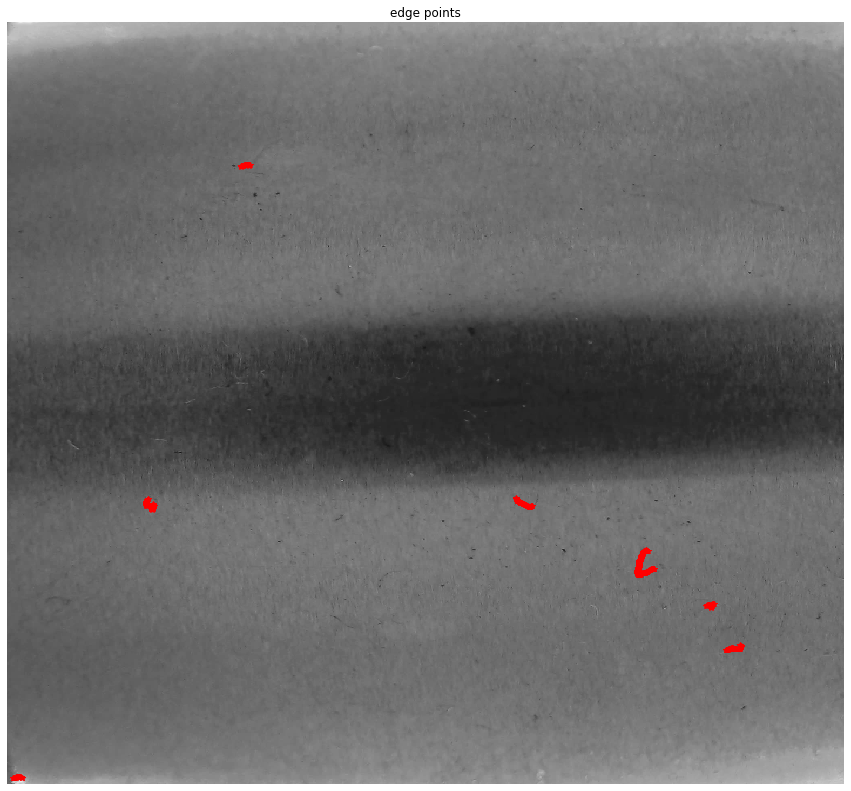

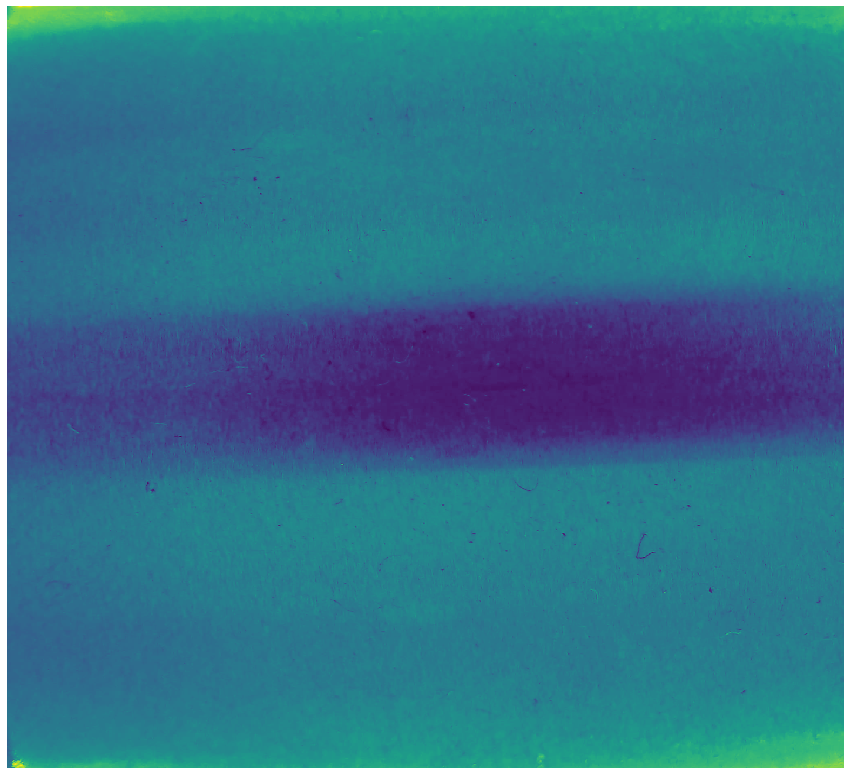

In [10]:
points = get_points(interactive_area.result, min_dist=10, allow_cluster=True)
overlay_points(img, points)
show_img(img, size=(15,15))